In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

**Choose input file**

In [2]:
comp_file = "gen_descriptors"
comp_sheet = "Sheet1"
num_par = 190
par_start_col = 2
comp_num_samples = 1560
y_label_col_comp = 0 

exp_file = "gen_rxn_data"
exp_sheet = "Phosphines"
exp_num_samples = 1776
response_col = 3
y_label_col_exp = 2

**Sort data**

In [3]:
compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))),engine='openpyxl')
compinp = compinp.drop(['smiles'],axis=1)
par_start_col = 1
compinp.index = compinp.index.map(str)

expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=2,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)),engine='openpyxl')

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]
X_labelname = [" ".join(i) for i in zip(X_labels,X_names)]
X_labelname_dict = dict(zip(X_labels,X_names))
resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)
mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X

print("Number of entries in experimental file before removing empty cells: {}".format(len(y)))
print("Removing {} entries with empty cells".format(len(y)-sum(mask)))

y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]
X = np.asarray(compinp.loc[y_labels],dtype=np.float)

print("Shape of descriptors file for all ligands: {}".format(X_all.shape))
print("Last three ids in the descriptor file: {}".format(y_labels_comp[-3:]))
print("Shape of descriptors file for ligands with experimental results: {}".format(X.shape))
print("Shape of results file results (only ligands with experimental results): {}".format(y.shape)) 
print("Shape of results file labels (only ligands with experimental results): {}".format(y_labels.shape))
print("First descriptor cell (for ligands with experimental results): {}".format(X[0,0]))
print('Ligands with results:',y_labels)
print('Experimental results:',y)

Number of entries in experimental file before removing empty cells: 1776
Removing 1730 entries with empty cells
Shape of descriptors file for all ligands: (1544, 190)
Last three ids in the descriptor file: ['1906' '1907' '1908']
Shape of descriptors file for ligands with experimental results: (46, 190)
Shape of results file results (only ligands with experimental results): (46,)
Shape of results file labels (only ligands with experimental results): (46,)
First descriptor cell (for ligands with experimental results): -0.0663027140355674
Ligands with results: ['3' '4' '6' '10' '11' '15' '17' '18' '19' '20' '32' '37' '42' '44' '50'
 '53' '54' '61' '62' '69' '72' '80' '81' '89' '91' '102' '104' '116' '157'
 '199' '232' '234' '239' '246' '250' '251' '266' '291' '292' '296' '309'
 '311' '327' '456' '728' '735']
Experimental results: [11. 26.  1.  1. 59.  1. 77. 81. 94. 74. 18.  1.  1. 30.  1.  1. 11. 81.
 80. 56. 84.  1. 36.  1. 16.  1.  1. 82. 46. 82.  1.  1. 76. 78. 15. 15.
 63.  1.  1.  1

**Standard threshold analysis (single-node decision tree)**

x87 vbur_vbur_min
Decision threshold = 58.22
Accuracy: 0.89
f1_score: 0.92
Number datapoints = 46


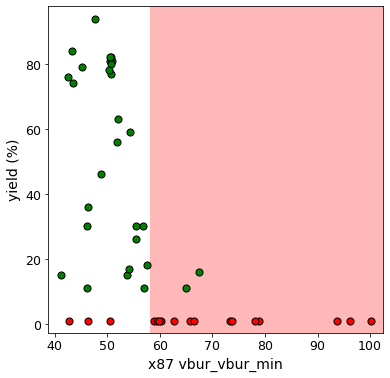

In [4]:
#features = range(len(X_labels))          # test all features
features = [86]                           # test single feature (Vmin (Boltz) = 0, Vbur (min) = 86) 

y_cut = 10.0 
y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes = 2
plot_colors = "rg"
plot_step = 0.02          # originally 0.02
accuracy_cutoff = 0.0      # filter thresholds based on accuracy cutoff

for f_ind in features:
    feature = X_labels[f_ind]
    dt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)
    if dt.score(X[:,f_ind].reshape(-1, 1), y_class) >= accuracy_cutoff:
        print(feature, X_names[f_ind])
        print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nNumber datapoints = {}".format(
            dt.tree_.threshold[0],dt.score(X[:,f_ind].reshape(-1, 1), y_class),metrics.f1_score(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),len(y)))
        dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)
        x_min, x_max = X[:,f_ind].min(), X[:,f_ind].max()
        y_min, y_max = y.min(), y.max()
        dx,dy = x_max-x_min,y_max-y_min
        xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
        plt.figure(figsize=(6, 6))    
        Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z,colors=['#ffb8b8','#FF000000','#FF000000','#FF000000'])
        pltlabel = X_labels[f_ind] + " " + X_names[f_ind]
        plt.xlabel(pltlabel,fontsize=14)
        plt.ylabel("yield (%)",fontsize=14)
        plt.xticks(fontsize=12.5)
        plt.yticks(fontsize=12.5)
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y_class == i)
            plt.scatter(X[idx, f_ind], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=50)    
        plt.show()

**Plot two descriptors with a colormap of reaction output**

*Set up for HTE 3aa THF/H2O selectivity results*

In [ ]:
plt.figure(figsize=(12, 8))
plt.xlabel("Vmin (Boltz)",fontsize=18)
plt.ylabel('Vbur (min., Å3)',fontsize=18)
plt.xticks(fontsize=18)
plt.xlim(-0.07, -0.035)
plt.locator_params(axis='x', nbins=4)
plt.ylim(40, 70)
plt.yticks(fontsize=18)
plt.locator_params(axis='y', nbins=5)
plt.scatter(X[:,0],X[:,86], c=y,cmap="bwr", edgecolor='black', s=200)
cbar = plt.colorbar()
cbar.set_label("Selectivity (ddG)",rotation=90,size=18)
cbar.ax.locator_params(nbins=5)
plt.clim(vmin=-1, vmax=1)
plt.show()

*Set up for HTE 3aa THF/H2O yield results*

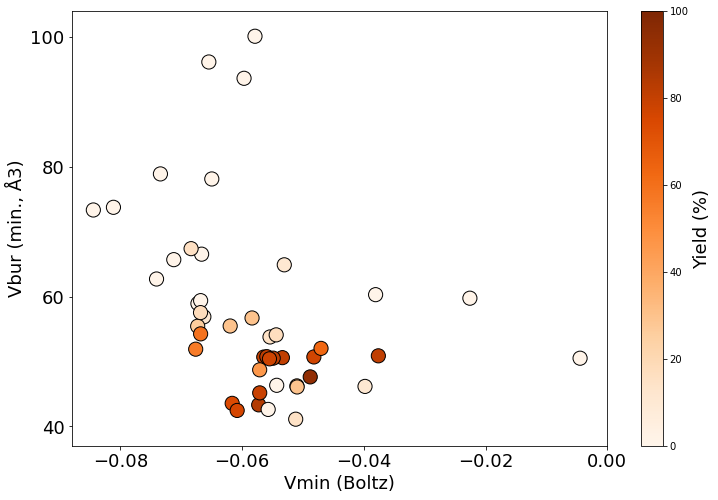

In [6]:
plt.figure(figsize=(12, 8))
plt.xlabel("Vmin (Boltz)",fontsize=18)
plt.ylabel('Vbur (min., Å3)',fontsize=18)
plt.xticks(fontsize=18)
plt.xlim(-0.088, 0)
plt.locator_params(axis='x', nbins=5)
plt.yticks(fontsize=18)
plt.ylim(37, 104)
plt.locator_params(axis='y', nbins=4)
plt.scatter(X[:,0],X[:,86], c=y,cmap="Oranges", edgecolor='black', s=200)
cbar = plt.colorbar()
cbar.set_label("Yield (%)", rotation=90,size=18)
plt.clim(vmin=0, vmax=100)
plt.show()